In [4]:
import torch
from torch import nn
from torch.nn import functional as F

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1) # Output size: [32, 32, 32]
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1) # Output size: [64, 16, 16]
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1) # Output size: [128, 8, 8]
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1) # Output size: [256, 4, 4]
        
        # Latent vectors mu and logvar
        self.fc1 = nn.Linear(256*4*4, 512)
        self.fc_mu = nn.Linear(512, 256)
        self.fc_logvar = nn.Linear(512, 256)

        # Decoder
        self.fc2 = nn.Linear(256, 256*4*4)
        self.conv5 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.conv6 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.conv7 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.conv8 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

    def encode(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = h.view(-1, 256*4*4)
        h = F.relu(self.fc1(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        h = h.view(-1, 256, 4, 4)
        h = F.relu(self.conv5(h))
        h = F.relu(self.conv6(h))
        h = F.relu(self.conv7(h))
        return torch.sigmoid(self.conv8(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class ChineseCharacterDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_names = os.listdir(folder_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(),  # Convert to monochrome
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.file_names[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        return image

dataset = ChineseCharacterDataset('data')
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
num_epochs = 10  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print(f"Epoch {epoch}, Average Loss: {train_loss / len(data_loader.dataset)}")


Epoch 0, Average Loss: -5217.672284836141
Epoch 1, Average Loss: -20887.295270737053
Epoch 2, Average Loss: -32255.39486754967
Epoch 3, Average Loss: -38892.690468816996
Epoch 4, Average Loss: -42927.75082185907
Epoch 5, Average Loss: -45751.76332841012
Epoch 6, Average Loss: -47939.08343656201
Epoch 7, Average Loss: -49750.902913430844
Epoch 8, Average Loss: -51270.586688265284
Epoch 9, Average Loss: -52618.088391538426


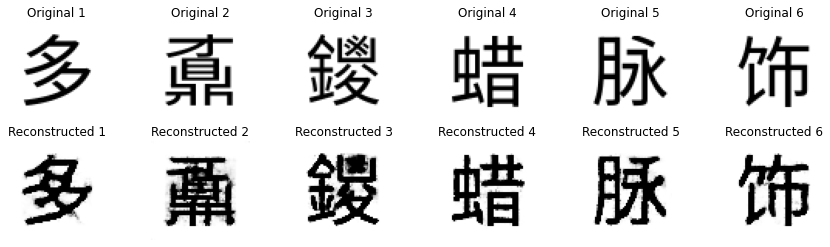

In [8]:
import matplotlib.pyplot as plt
import torch

def show_reconstructions(model, data_loader, num_images=6):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        # Get a batch of images
        for batch in data_loader:
            batch = batch.to(device)
            recon, _, _ = model(batch)
            break  # We only need one batch

    batch = batch.cpu()
    recon = recon.cpu()

    fig, axs = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        # Display original images
        axs[0, i].imshow(batch[i].reshape(64, 64), cmap='gray')
        axs[0, i].set_title(f"Original {i+1}")
        axs[0, i].axis('off')

        # Display reconstructed images
        axs[1, i].imshow(recon[i].reshape(64, 64), cmap='gray')
        axs[1, i].set_title(f"Reconstructed {i+1}")
        axs[1, i].axis('off')

    plt.show()

# Assuming you already have your model and data_loader
show_reconstructions(model, data_loader, num_images=6)

Epoch 0, Average Loss: -51612.588594025445
Epoch 1, Average Loss: -55053.327361951495
Epoch 2, Average Loss: -55797.742531802374
Epoch 3, Average Loss: -56364.97393872981
Epoch 4, Average Loss: -56911.364714850635
Epoch 5, Average Loss: -57344.08914193149
Epoch 6, Average Loss: -57731.809471627996
Epoch 7, Average Loss: -58131.41326409071
Epoch 8, Average Loss: -58477.80137214732
Epoch 9, Average Loss: -58767.57301443613
Epoch 10, Average Loss: -59099.22754776311
Epoch 11, Average Loss: -59376.067273333654
Epoch 12, Average Loss: -59653.62751917671
Epoch 13, Average Loss: -59877.90861880033
Epoch 14, Average Loss: -60117.71227785983
Epoch 15, Average Loss: -60371.62885320882
Epoch 16, Average Loss: -60557.96293296489
Epoch 17, Average Loss: -60763.23621897184
Epoch 18, Average Loss: -60949.43565677259
Epoch 19, Average Loss: -61123.46171804278
Epoch 20, Average Loss: -61309.38667873648
Epoch 21, Average Loss: -61495.23283624756
Epoch 22, Average Loss: -61674.00786126066
Epoch 23, Avera

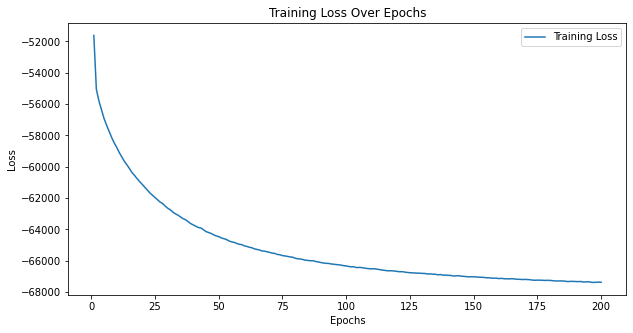

In [11]:
import matplotlib.pyplot as plt
import os

# Create 'saved_models' directory if it doesn't exist
saved_models_dir = 'saved_models'
if not os.path.exists(saved_models_dir):
    os.makedirs(saved_models_dir)

# Initialize loss tracking
epoch_losses = []

# Set the number of epochs
num_epochs = 200  # Example, set this as needed

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    average_loss = train_loss / len(data_loader.dataset)
    epoch_losses.append(average_loss)
    print(f"Epoch {epoch}, Average Loss: {average_loss}")

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
        save_path = os.path.join(saved_models_dir, f'model_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), save_path)

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

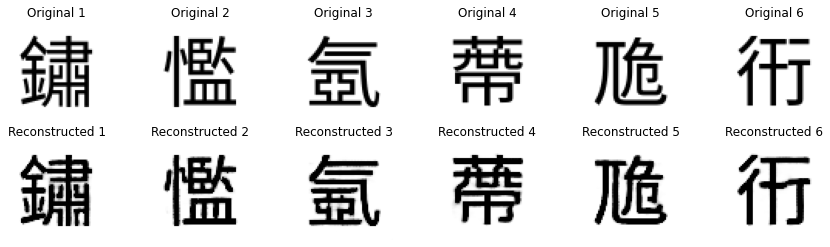

In [12]:
# Assuming you already have your model and data_loader
show_reconstructions(model, data_loader, num_images=6)

Adding in train-test split

In [2]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os

class ChineseCharacterDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_names = os.listdir(folder_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(),  # Convert to monochrome
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.file_names[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        return image

dataset = ChineseCharacterDataset('data')
# data_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Train-test split
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% of the dataset for training
test_size = total_size - train_size  # Remaining 20% for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)

Epoch 0, Training Loss: 1566.1551817193736, Test Loss: 683.1752248094331
Epoch 1, Training Loss: 87.09208808150572, Test Loss: -518.5073528317056
Epoch 2, Training Loss: -1096.556949221309, Test Loss: -2104.994469092425
Epoch 3, Training Loss: -2585.8319896075277, Test Loss: -3040.906670587184
Epoch 4, Training Loss: -4165.7317089512235, Test Loss: -5031.31226179133
Epoch 5, Training Loss: -6001.438121612769, Test Loss: -6990.449782634588
Epoch 6, Training Loss: -8296.823447084747, Test Loss: -9342.28657991901
Epoch 7, Training Loss: -10593.394377940564, Test Loss: -10803.863833968557
Epoch 8, Training Loss: -12703.872133881247, Test Loss: -13456.975077417817
Epoch 9, Training Loss: -15027.849592043356, Test Loss: -16063.772361838972
Epoch 10, Training Loss: -17450.436334941336, Test Loss: -17876.145843258695
Epoch 11, Training Loss: -19954.764874039665, Test Loss: -21292.944259171032
Epoch 12, Training Loss: -22641.65011017807, Test Loss: -23681.149178180087
Epoch 13, Training Loss: -

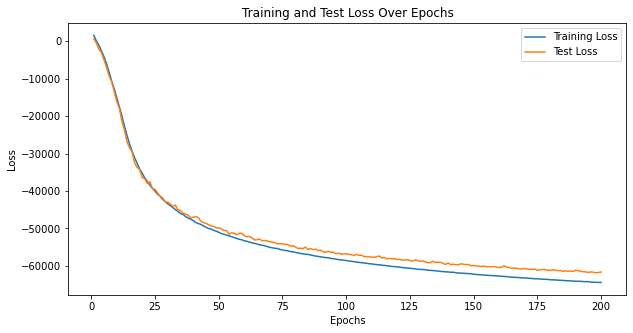

In [9]:
import matplotlib.pyplot as plt
import os

# Create 'saved_models' directory if it doesn't exist
saved_models_dir = 'saved_models'
if not os.path.exists(saved_models_dir):
    os.makedirs(saved_models_dir)

# Initialize loss tracking
train_losses = []
test_losses = []

# Set the number of epochs
num_epochs = 200  # Example, set this as needed

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation (test) phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            test_loss += loss_function(recon, data, mu, logvar).item()
    
    # Calculate average test loss
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(f"Epoch {epoch}, Training Loss: {train_loss}, Test Loss: {test_loss}")

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
        save_path = os.path.join(saved_models_dir, f'model_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), save_path)

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

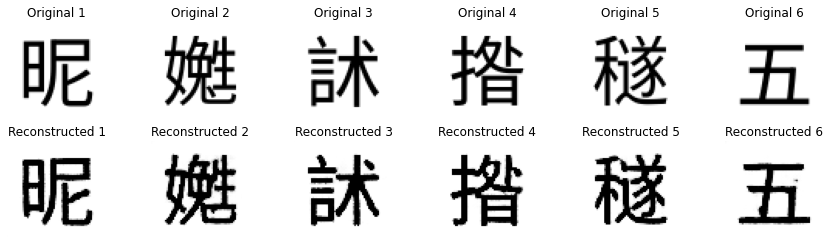

In [10]:
import matplotlib.pyplot as plt
import torch

def show_reconstructions(model, data_loader, num_images=6):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        # Get a batch of images
        for batch in data_loader:
            batch = batch.to(device)
            recon, _, _ = model(batch)
            break  # We only need one batch

    batch = batch.cpu()
    recon = recon.cpu()

    fig, axs = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        # Display original images
        axs[0, i].imshow(batch[i].reshape(64, 64), cmap='gray')
        axs[0, i].set_title(f"Original {i+1}")
        axs[0, i].axis('off')

        # Display reconstructed images
        axs[1, i].imshow(recon[i].reshape(64, 64), cmap='gray')
        axs[1, i].set_title(f"Reconstructed {i+1}")
        axs[1, i].axis('off')

    plt.show()

# Assuming you already have your model and data_loader
show_reconstructions(model, test_loader, num_images=6)

In [17]:
import torch
import os
from torch import nn

def load_model(model_path, model_architecture):
    """
    Loads a model from the specified path onto the GPU.

    Args:
    model_path (str): Path to the .pth file of the saved model.
    model_architecture (nn.Module): The architecture of the model (should match the saved model).

    Returns:
    The loaded model.
    """
    if not os.path.isfile(model_path):
        print(f"Model file not found: {model_path}")
        return None

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Loading model on: {device}")

    model = model_architecture().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

# Example usage
model_path = './saved_models/model_epoch_200.pth'
loaded_model = load_model(model_path, VAE)

# Do something with loaded_model, like evaluation or further training


Loading model on: cuda


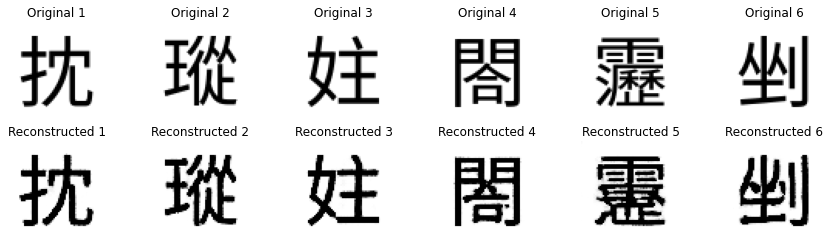

In [18]:
show_reconstructions(loaded_model, test_loader, num_images=6)

TODO: clean up notebook

In [29]:
from torchviz import make_dot

# Your VAE class definition here...

# Create a dummy input (adjust the size according to your model's input)
dummy_input = torch.randn(1, 1, 64, 64).to(device)

# Forward pass through the model
# Note: Since your forward method returns multiple outputs, you should select one for visualization. 
# Here, I'm selecting the first output which represents the decoded image.
output = loaded_model(dummy_input)[0]

# Visualize the model
graph = make_dot(output, params=dict(loaded_model.named_parameters()))
graph.render('model_visualization', format='png')


'model_visualization.png'

In [26]:
# Assuming you already have your data_loader
data_iter = iter(test_loader)
single_instance = next(data_iter)


In [28]:
single_instance.shape

torch.Size([512, 1, 64, 64])